In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical

2022-03-05 20:04:24.082746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-05 20:04:24.082786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
transactions = pd.read_csv('../raw_data/transactions_train.csv', nrows=50_000)

In [4]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t_dat             50000 non-null  object 
 1   customer_id       50000 non-null  object 
 2   article_id        50000 non-null  int64  
 3   price             50000 non-null  float64
 4   sales_channel_id  50000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.9+ MB


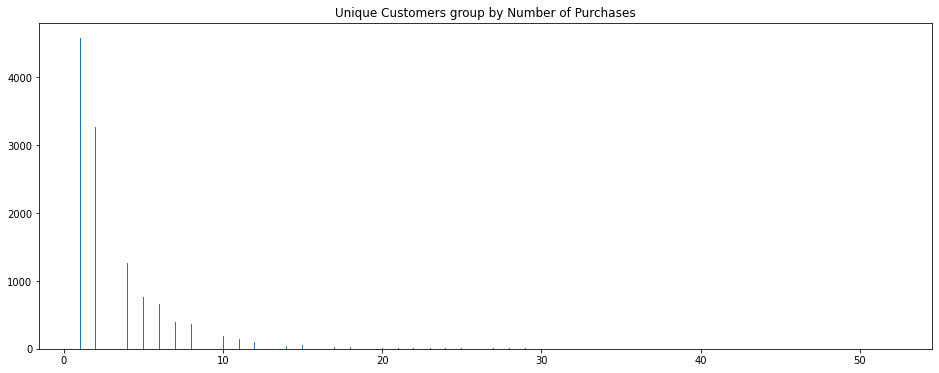

In [6]:
customer_purchases = pd.DataFrame(transactions['customer_id'].value_counts())
customer_purchases.rename(columns={'customer_id':'purchases'}, inplace=True)
plt.figure(figsize=(16,6))
plt.title('Unique Customers group by Number of Purchases')
plt.hist(customer_purchases, bins=1000)
plt.show()

In [7]:
transactions['article_id'] = transactions['article_id'].astype(str)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transactions['article_id'])
vocab_size = len(tokenizer.word_counts)+1
transactions['article_token'] = transactions['article_id'].map(tokenizer.word_index)

In [8]:
data = transactions.groupby('customer_id')['article_token'].apply(list)
data = pd.DataFrame(data).rename(columns={'article_token':'purchase_history'})

In [9]:
max_len = max([len(history) for history in data['purchase_history'].values])
sequence = pad_sequences(data['purchase_history'].values, maxlen=max_len, padding='pre')
sequence.shape

(14392, 52)

In [10]:
X = sequence[:, :-1]
y = sequence[:, -1]

In [11]:
y = to_categorical(y)

In [12]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 5, input_length = max_len-1))
model.add(layers.Dense(units=512))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(3))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(y.shape[1], activation='softmax'))
model.summary()

2022-03-05 20:04:29.595541: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-05 20:04:29.595597: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-UACK70L0): /proc/driver/nvidia/version does not exist
2022-03-05 20:04:29.596522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 5)             58635     
                                                                 
 dense (Dense)               (None, 51, 512)           3072      
                                                                 
 dropout (Dropout)           (None, 51, 512)           0         
                                                                 
 lstm (LSTM)                 (None, 3)                 6192      
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 11722)             46888     
                                                                 
Total params: 114,787
Trainable params: 114,787
Non-trai

In [13]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
history = model.fit(X, y, validation_split=0.2, verbose=1, epochs=10)

Epoch 1/10


2022-03-05 20:04:29.912492: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 539821544 exceeds 10% of free system memory.


360/360 [==============================] - 16s 39ms/step - loss: 9.1961 - accuracy: 0.0051 - val_loss: 9.0430 - val_accuracy: 0.0066
Epoch 2/10
360/360 [==============================] - 18s 50ms/step - loss: 8.6658 - accuracy: 0.0052 - val_loss: 9.0067 - val_accuracy: 0.0056
Epoch 3/10
360/360 [==============================] - 16s 46ms/step - loss: 8.4706 - accuracy: 0.0055 - val_loss: 9.0621 - val_accuracy: 0.0056
Epoch 4/10
360/360 [==============================] - 19s 54ms/step - loss: 8.3730 - accuracy: 0.0058 - val_loss: 9.1083 - val_accuracy: 0.0056
Epoch 5/10
360/360 [==============================] - 34s 93ms/step - loss: 8.3096 - accuracy: 0.0059 - val_loss: 9.1804 - val_accuracy: 0.0056
Epoch 6/10
360/360 [==============================] - 39s 109ms/step - loss: 8.2565 - accuracy: 0.0055 - val_loss: 9.2204 - val_accuracy: 0.0056
Epoch 7/10
360/360 [==============================] - 37s 104ms/step - loss: 8.2138 - accuracy: 0.0057 - val_loss: 9.2718 - val_accuracy: 0.0056
E

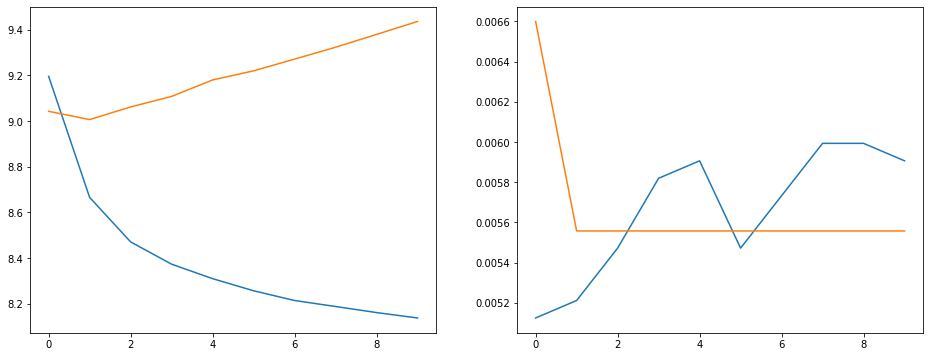

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='val loss')
ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='val accuracy')
plt.show()